In [46]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

def create_geometry(x1,x2,y1,y2):
    elements = []
    element = {}
    for i in range(len(x1)):
        element["x1"] = x1[i]
        element["y1"] = y1[i]
        element["x2"] = x2[i]
        element["y2"] = y2[i]
        elements.append(element.copy())
    elements = bemcs.standardize_elements(elements)
    return elements

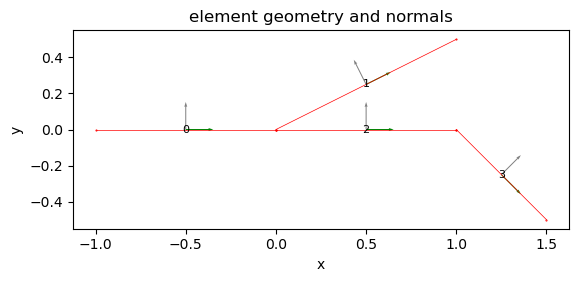

In [47]:
# Elastic parameters
mu = 1
nu = 0.25

x1 = np.array((-1.,0,0,1.))
x2 = np.array((0.,1.,1.,1.5))
y1 = np.array((0.,0.,0.,0.))
y2 = np.array((0.,0.5,-0.,-0.5))

elements = create_geometry(x1,x2,y1,y2)
n_elements = len(elements)

# slip vector
slip_vector_x = np.array((1.0,0.5,0.5,0.2))
slip_vector_y = np.array((0.,0.0,1.,0.))

plt.figure()
bemcs.plot_element_geometry(elements)
plt.show()

In [48]:
# observation point
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile stress kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

### Boundary Conditions and Design Matrix

The number of equations for a given system with $N$ fault elements can be calculated as follows:
1. $2N$ equations for the central node of every element
2. $2N_o$ equations at the open nodes, where $N_o$ is the number of nodes that belong to only 1 fault element
3. $4N_i$ equations applied at $N_i$ interior nodes, where an interior node is any node that is shared by exactly 2 fault elements. 
4. $6N_t$ equations at triple junctions where $N_t$ is the number of triple junctions.

There are $6N$ unknown $3qn$ coefficients we need to solve for. Below we discuss the shape of the design matrix for a few typical cases:
- When the domain is a simply connected closed loop, there are no open nodes and no triple junctions, we have
  - $2N$ equations for the central node, $4N$ equations at the interior nodes
- When the domain is an open loop, there are $2$ open nodes at the ends of the mesh and we have
  - $2N$ equations for the central node, $4N-4$ equations at the interior nodes, $4$ equations at the open nodes
- For the case considered in this example, we have $N=3$ elements with $3$ open nodes and $1$ triple junction, and no other interior nodes. $6$ equations for the central node, $6$ equations at the open nodes and $6$ equations at the triple junction, and the rest are for any other interior nodes (2-element overlaps)


## Labeling Nodes as Open, 2-overlap or triple junctions

We first go through all the end nodes of our mesh ($(x_1,y_1) \cup (x_2,y_2)$), find the unique ones and then label them as open, an interior node (overlap of exactly 2 elements) or a triple junction. We construct our boundary conditions and linear opeartor accordingly.

In [49]:
# first find all unique points
points = np.vstack((np.hstack((x1.reshape(-1,1),y1.reshape(-1,1))),np.hstack((x2.reshape(-1,1),y2.reshape(-1,1)))))

unique_points, id_unique = np.unique(points, axis = 0, return_index=True)

# find number of open, 2-overlap & triple junction nodes
index_matrix1 = []
index_matrix2 = []
index_matrix3 = []

for i in range(len(unique_points)):
    pts = unique_points[i,:].reshape(1,-1)
    
    # which element(s) contains this point 
    id1 = np.where(np.all(pts == np.hstack((x1.reshape(-1,1),y1.reshape(-1,1))), axis = 1))
    id2 = np.where(np.all(pts == np.hstack((x2.reshape(-1,1),y2.reshape(-1,1))), axis = 1))

    # the negative signs are for the triple junction equations 
    # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2 
    if np.size(id1) == 2:
        id_combo = np.hstack((-id1[0]*3,id2[0]*3 + 2))
    elif np.size(id2) == 2:
        id_combo = np.hstack((id1[0]*3,-(id2[0]*3 + 2)))
    else:
        id_combo = np.hstack((id1[0]*3,id2[0]*3 + 2))

    if np.size(id_combo) == 1:
        index_matrix1.append(id_combo)
    elif np.size(id_combo) == 2:
        index_matrix2.append(id_combo)
    elif np.size(id_combo) == 3:
        index_matrix3.append(id_combo)
    else:
        raise ValueError("Cannot deal with more than 3 lines at a node")

print("Number of open nodes =", len(index_matrix1), ":", index_matrix1)
print("Number of 2-overlap nodes =", len(index_matrix2), ":", index_matrix2)
print("Number of triple junctions =", len(index_matrix3), ":", index_matrix3)

N_c = 2*len(elements) # central node equations
N_o = 2*len(index_matrix1) # open node equations
N_i = 4*len(index_matrix2) # overlapping node equations
N_t = 6*len(index_matrix3) # triple junction equations

Number of open nodes = 3 : [array([0]), array([5]), array([11])]
Number of 2-overlap nodes = 1 : [array([9, 8])]
Number of triple junctions = 1 : [array([-3, -6,  2])]


In [50]:
# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements,flag="node")
matrix_slip_mean,_ = kernels.get_designmatrix_xy_3qn(elements,flag="mean")

# Nequations = N_c + N_o + N_i + N_t
Nequations = N_c + N_o + N_i + N_t
Nunknowns = len(elements)*6

# We will stack this with 
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c,1)) # these are the only non-zero entries
BC_o = np.zeros((N_o,1))
BC_i = np.zeros((N_i,1))
BC_t = np.zeros((N_t,1))

# slip boundary condition for element centers
BC_c[0:N_c:2] = slip_vector_x.reshape((-1,1))
BC_c[1:N_c:2] = slip_vector_y.reshape((-1,1))

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c,BC_o,BC_i,BC_t))

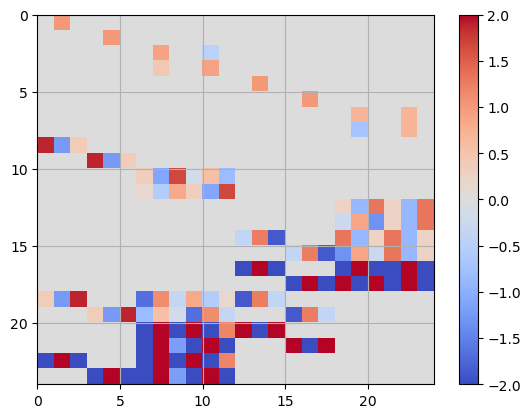

In [51]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c,Nunknowns))
matrix_system_o = np.zeros((N_o,Nunknowns))
matrix_system_i = np.zeros((N_i,Nunknowns))
matrix_system_t = np.zeros((N_t,Nunknowns))

# Linear operator for central node BCs 
matrix_system_c[0:N_c:2,:] = matrix_slip[2::6,:] # x component
matrix_system_c[1:N_c:2,:] = matrix_slip[3::6,:] # y component

# Linear operator for open nodes
for i in range(int(N_o/2)):
    id1 = index_matrix1[i] # node number
    matrix_system_o[2*i,:] = matrix_slip[2*id1,:] # x component
    matrix_system_o[2*i+1,:] = matrix_slip[2*id1+1,:] # y component

# Linear operator for overlapping nodes
for i in range(int(N_i/4)):
    idvals = index_matrix2[i] # node number
    # continuity condition
    matrix_system_i[4*i,:] = matrix_slip[2*idvals[0],:] - matrix_slip[2*idvals[1],:] # x
    matrix_system_i[4*i+1,:] = matrix_slip[2*idvals[0]+1,:] - matrix_slip[2*idvals[1]+1,:] # y
    # smoothing constraints
    matrix_system_i[4*i+2,:] = matrix_slipgradient[2*idvals[0],:] - matrix_slipgradient[2*idvals[1],:] # x
    matrix_system_i[4*i+3,:] = matrix_slipgradient[2*idvals[0]+1,:] - matrix_slipgradient[2*idvals[1]+1,:] # y


# Linear operator for triple junction nodes
for i in range(int(N_t/6)):
    id1 = index_matrix3[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0] # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0] # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg)==2:
        matrix_system_t[6*i,:] = matrix_slip[2*id_pos,:] - matrix_slip[2*id_neg[0],:] - matrix_slip[2*id_neg[1],:] # x component
        matrix_system_t[6*i+1,:] = matrix_slip[2*id_pos+1,:] - matrix_slip[2*id_neg[0]+1,:] - matrix_slip[2*id_neg[1]+1,:] # y component
    else:
        matrix_system_t[6*i,:] = matrix_slip[2*id_pos[0],:] + matrix_slip[2*id_pos[1],:] - matrix_slip[2*id_neg,:] # x component
        matrix_system_t[6*i+1,:] = matrix_slip[2*id_pos[0]+1,:] + matrix_slip[2*id_pos[1]+1,:] - matrix_slip[2*id_neg+1,:] # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6*i+2,:] = matrix_slipgradient[2*idvals[0],:] - matrix_slipgradient[2*idvals[1],:] # x
    matrix_system_t[6*i+3,:] = matrix_slipgradient[2*idvals[0]+1,:] - matrix_slipgradient[2*idvals[1]+1,:] # y
    matrix_system_t[6*i+4,:] = matrix_slipgradient[2*idvals[0],:] - matrix_slipgradient[2*idvals[2],:] # x
    matrix_system_t[6*i+5,:] = matrix_slipgradient[2*idvals[0]+1,:] - matrix_slipgradient[2*idvals[2]+1,:] # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack((matrix_system_c,matrix_system_o,matrix_system_i,matrix_system_t))

# plot design matrix
_,ax = plt.subplots()
pc = ax.pcolor(matrix_system,cmap="coolwarm",shading='flat')
ax.grid(which='both')
ax.invert_yaxis()
pc.set_clim(-2,2)
plt.colorbar(pc)
plt.show()


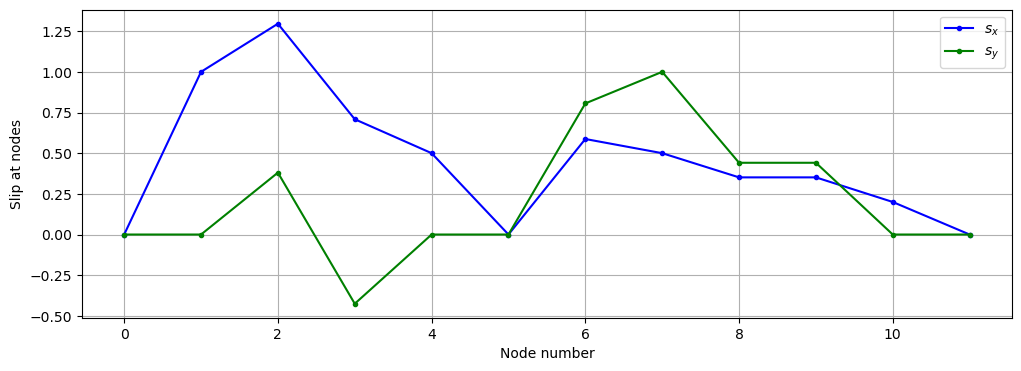

[[ 1.29577901  0.38047271]
 [ 0.70865368 -0.42538142]
 [ 0.58712533  0.80585412]]


In [52]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
# quadratic_coefs = np.linalg.lstsq(matrix_system,BCvector)[0]

# print(matrix_system@quadratic_coefs - BCvector)

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

# extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x,slip_nodes_y))
# rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3*len(elements),1))
slip_nodes_n = np.zeros((3*len(elements),1))

for i in range(len(elements)):
    dummy = slip_vector[3*i:3*(i+1),:]@elements[i]["rotation_matrix"]
    slip_nodes_s[3*i:3*(i+1),0] = dummy[:,0]
    slip_nodes_n[3*i:3*(i+1),0] = dummy[:,1]

xnodes = np.zeros((3*len(elements),1))
xnodes[0::3,0] = x1
xnodes[2::3,0] = x2
xnodes[1::3,0] = 0.5*(x1 + x2)

plt.figure(figsize=(12,4))
plt.plot(slip_nodes_x,'b.-',label='$s_x$')
plt.plot(slip_nodes_y,'g.-',label='$s_y$')
plt.xlabel("Node number")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.show()

print(np.hstack((slip_nodes_x[[2,3,6]],slip_nodes_y[[2,3,6]])))


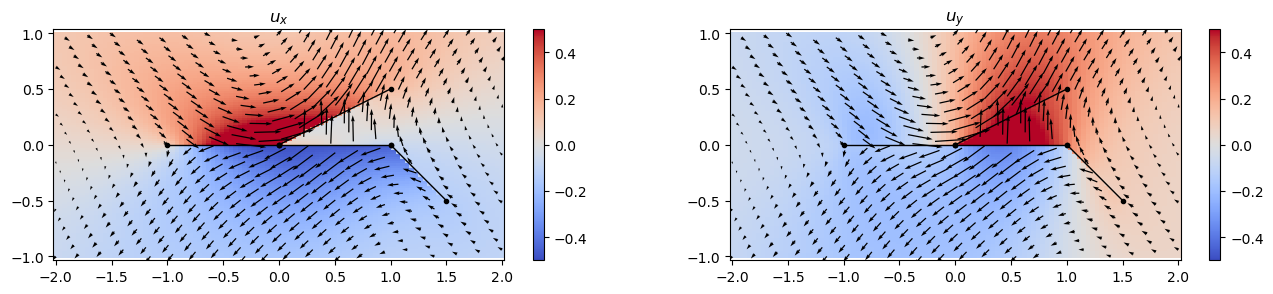

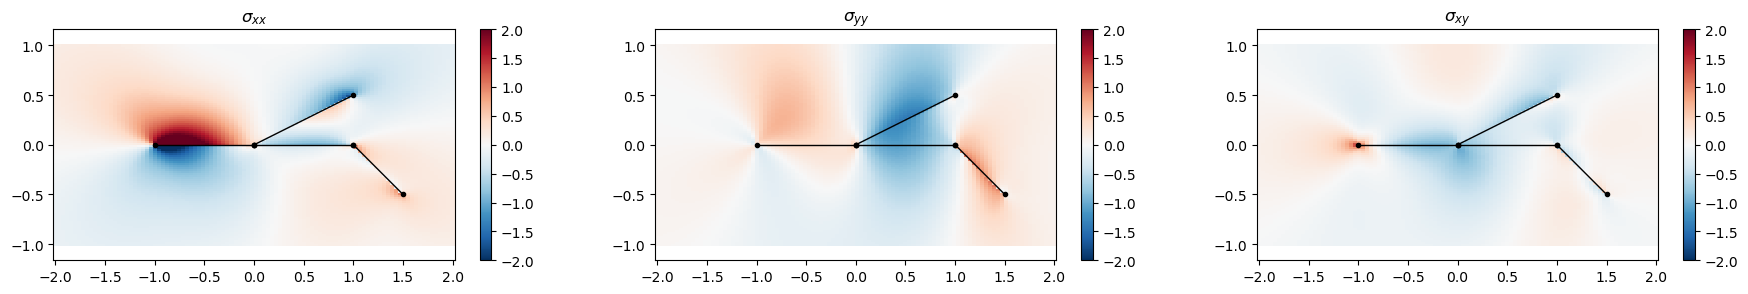

In [53]:
# kernels_s[6]
# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

nskip_plot = 21 # plotting for vectors

# displacements
plt.figure(figsize=(16,3))
plt.subplot(1, 2, 1)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), ux.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), uy.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = sxx
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdBu_r',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = syy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdBu_r',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = sxy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdBu_r',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()


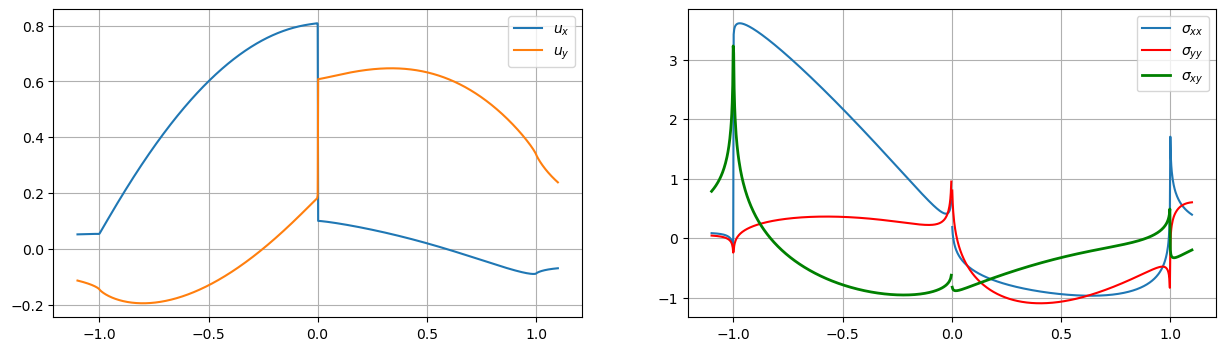

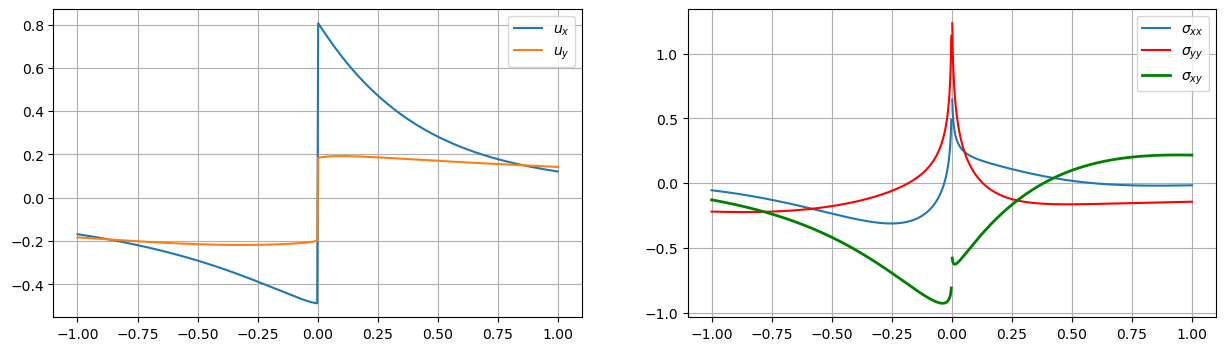

In [54]:
# # unit vector in normal & shear direction
# nvec = np.zeros((n_elements,2))
# for i in range(n_elements):
#     nvec[i,:] = np.array((elements[i]["x_normal"],elements[i]["y_normal"]))
# svec = np.zeros((n_elements,2))
# for i in range(n_elements):
#     svec[i,:] = np.array((elements[i]["x_shear"],elements[i]["y_shear"]))

# evaluate stresses at all the element nodes
# epsilon_n = 1e-8
# epsilon_s = 1e-2
# x_obs = np.zeros((3*len(elements),1))
# y_obs = np.zeros((3*len(elements),1))
# x_obs[0::3,0] = x1 + (nvec[:,0]*epsilon_n + svec[:,0]*epsilon_s)
# x_obs[2::3,0] = x2 + (nvec[:,0]*epsilon_n - svec[:,0]*epsilon_s)
# x_obs[1::3,0] = 0.5*(x1 + x2) + nvec[:,0]*epsilon_n
# y_obs[0::3,0] = y1 + (nvec[:,1]*epsilon_n + svec[:,1]*epsilon_s)
# y_obs[2::3,0] = y2 + (nvec[:,1]*epsilon_n - svec[:,1]*epsilon_s)
# y_obs[1::3,0] = 0.5*(y1 + y2) + nvec[:,1]*epsilon_n

# print(np.hstack((x_obs,y_obs)))

# plot along x-axis
x_obs = np.linspace(-1.1,1.1,1001).reshape(-1,1)
y_obs = 1e-8 + x_obs*0
# compute shear and tensile stress kernels
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)
# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x_obs,ux,'-',label='$u_x$')
plt.plot(x_obs,uy,'-',label='$u_y$')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(x_obs,sxx,'-',label='$\sigma_{xx}$')
plt.plot(x_obs,syy,'r-',label='$\sigma_{yy}$')
plt.plot(x_obs,sxy,'g-',label='$\sigma_{xy}$',linewidth=2)
plt.legend()
plt.grid()
plt.show()

# plot along y-axis
y_obs = np.linspace(-1.0,1.0,1001).reshape(-1,1)
x_obs = -1e-8 + y_obs*0
# compute shear and tensile stress kernels
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)
# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(y_obs,ux,'-',label='$u_x$')
plt.plot(y_obs,uy,'-',label='$u_y$')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(y_obs,sxx,'-',label='$\sigma_{xx}$')
plt.plot(y_obs,syy,'r-',label='$\sigma_{yy}$')
plt.plot(y_obs,sxy,'g-',label='$\sigma_{xy}$',linewidth=2)
plt.legend()
plt.grid()
plt.show()